In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import datetime, timedelta

In [2]:
pd.set_option('display.max_rows', 500)

In [3]:
file_path = 'C:/Users/Jacob/Documents/datasets/mimic-iii-1.4/'
save_path = 'C:/Users/Jacob/Documents/datasets/mimic-iii-1.4-processed/'
if not os.path.exists(save_path):
    os.mkdir(save_path)

In [4]:
adm = pd.read_csv(os.path.join(file_path, "ADMISSIONS.csv"))
adm.head()

ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

  DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1       NaN       ELECTIVE  PHYS REFERRAL/NORMAL DELI   
2       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3       NaN      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
4       NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

          DISCHARGE_LOCATION INSURANCE LANGUAGE           RELIGION  \
0  DISC-TRAN CANCER/CHLDRN H   Private      NaN       UNOBTAINABLE   
1           HOME HEALTH CARE  Medicare      NaN           CATHOLIC   
2           HOME HEALTH CARE  Medicare     ENGL           CATHOLIC   
3                       HOME   Private      NaN  PROTESTANT QUAKER   
4                       HOME   Private      NaN       UNOBTAINABLE   

  MARITAL_STATUS ETHNICITY            EDREGTIME            EDOUTTIME  \
0        MARRIED     WHITE  2196-04-09 10:06:00  2196-04-09 13:24:00   
1        MARRIED     WHITE                  NaN                  NaN   
2        MARRIED     WHITE                  NaN                  NaN   
3         SINGLE     WHITE                  NaN                  NaN   
4        MARRIED     WHITE  2160-11-02 01:01:00  2160-11-02 04:27:00   

                                           DIAGNOSIS  HOSPITAL_EXPIRE_FLAG  \
0                            BENZODIAZEPINE OVERDOSE                     0   
1  CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...                     0   
2                                         BRAIN MASS                     0   
3                     INTERIOR MYOCARDIAL INFARCTION                     0   
4                            ACUTE CORONARY SYNDROME                     0   

   HAS_CHARTEVENTS_DATA  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [5]:
icu = pd.read_csv(os.path.join(file_path, "ICUSTAYS.csv"))
# Only include carevue patients so there is no overlap with MIMIC-iv
icu = icu.loc[icu["DBSOURCE"] == "carevue"]
icu.head()

ROW_ID  SUBJECT_ID  HADM_ID  ICUSTAY_ID DBSOURCE FIRST_CAREUNIT  \
0     365         268   110404      280836  carevue           MICU   
1     366         269   106296      206613  carevue           MICU   
2     367         270   188028      220345  carevue            CCU   
3     368         271   173727      249196  carevue           MICU   
4     369         272   164716      210407  carevue            CCU   

  LAST_CAREUNIT  FIRST_WARDID  LAST_WARDID               INTIME  \
0          MICU            52           52  2198-02-14 23:27:38   
1          MICU            52           52  2170-11-05 11:05:29   
2           CCU            57           57  2128-06-24 15:05:20   
3          SICU            52           23  2120-08-07 23:12:42   
4           CCU            57           57  2186-12-25 21:08:04   

               OUTTIME     LOS  
0  2198-02-18 05:26:11  3.2490  
1  2170-11-08 17:46:57  3.2788  
2  2128-06-27 12:32:29  2.8939  
3  2120-08-10 00:39:04  2.0600  
4  2186-12-27 12:01:13  1.6202

In [6]:
pat = pd.read_csv(os.path.join(file_path, 'PATIENTS.csv'))
pat.head()

ROW_ID  SUBJECT_ID GENDER                  DOB                  DOD  \
0     234         249      F  2075-03-13 00:00:00                  NaN   
1     235         250      F  2164-12-27 00:00:00  2188-11-22 00:00:00   
2     236         251      M  2090-03-15 00:00:00                  NaN   
3     237         252      M  2078-03-06 00:00:00                  NaN   
4     238         253      F  2089-11-26 00:00:00                  NaN   

              DOD_HOSP DOD_SSN  EXPIRE_FLAG  
0                  NaN     NaN            0  
1  2188-11-22 00:00:00     NaN            1  
2                  NaN     NaN            0  
3                  NaN     NaN            0  
4                  NaN     NaN            0

In [7]:
print(len(adm))
adm = adm[adm["SUBJECT_ID"].isin(list(icu["SUBJECT_ID"]))]
print(len(adm))

58976
39205


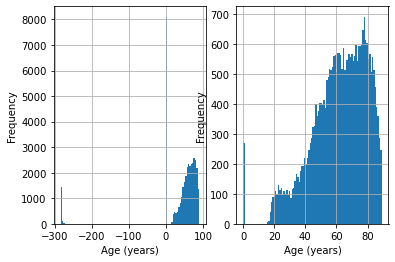

In [8]:
# Calculate the age of a patient on admission to the hospital.
adm["ADMITTIME"] = pd.to_datetime(adm["ADMITTIME"], format='%Y-%m-%d %H:%M:%S')
pat["DOBTIME"] = pd.to_datetime(pat["DOB"], format='%Y-%m-%d')
adm = pd.merge(pat[["SUBJECT_ID","DOBTIME"]], adm, on="SUBJECT_ID")
adm["age"] = (adm["ADMITTIME"].subtract(adm["DOBTIME"])).dt.days / 365
plt.figure()
plt.subplot(1, 2, 1)
adm["age"].hist(bins=100)
_ = plt.xlabel('Age (years)'), plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
adm["age"].loc[adm["age"] > 0].hist(bins=100)
_ = plt.xlabel('Age (years)'), plt.ylabel('Frequency')

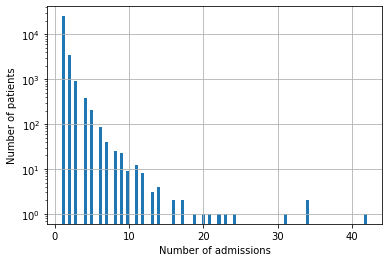

In [9]:
# Number of admissions by patient
df = adm.groupby('SUBJECT_ID')['HADM_ID'].nunique()
fig, ax = plt.subplots()
df.hist(ax=ax, bins=100)
_ = ax.set_yscale('log'), plt.xlabel('Number of admissions'), plt.ylabel('Number of patients'), plt.show()

In [10]:
# Filter patients with more than 1 admission
adm = adm.loc[adm['SUBJECT_ID'].isin(list(df[df==1].index))]
print("Number of patients remaining in the dataframe: ")
print(len(adm.index))

Number of patients remaining in the dataframe: 
25233


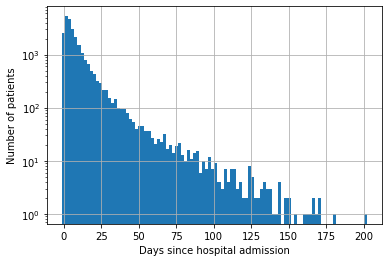

In [11]:
# Add a new column with the duration of each stay.
adm["DISCHTIME"] = pd.to_datetime(adm["DISCHTIME"], format='%Y-%m-%d %H:%M:%S')
adm["ELAPSED_TIME"] = adm["DISCHTIME"] - adm["ADMITTIME"]
adm["ELAPSED_DAYS"] = adm["ELAPSED_TIME"].dt.days  # Elapsed time in days in ICU
fig, ax = plt.subplots()
adm["ELAPSED_DAYS"].hist(ax=ax, bins=100)
_ = ax.set_yscale('log'), plt.xlabel('Days since hospital admission'), plt.ylabel('Number of patients'), plt.show()

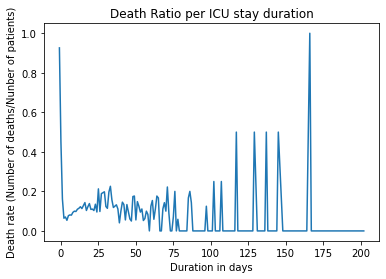

In [12]:
# The death rate in function of the duration stay in ICU.
df_deaths_per_duration = adm.groupby("ELAPSED_DAYS")["HOSPITAL_EXPIRE_FLAG"].sum()
df_patients_per_duration = adm.groupby("ELAPSED_DAYS")["SUBJECT_ID"].nunique()
df_death_ratio_per_duration = df_deaths_per_duration / df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

In [13]:
adm = adm.loc[(adm["ELAPSED_DAYS"] < 30) & (adm["ELAPSED_DAYS"] > 2)]
print("Number of patients with more than 2 and less than 30 days: ")
print(adm["SUBJECT_ID"].nunique())

Number of patients with more than 2 and less than 30 days: 
18124


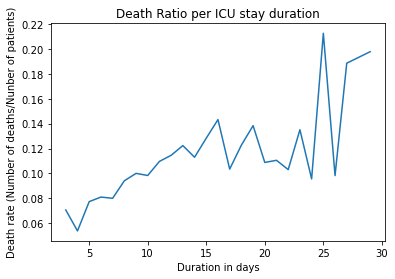

In [14]:
# The death rate in function of the duration stay in ICU.
df_deaths_per_duration = adm.groupby("ELAPSED_DAYS")["HOSPITAL_EXPIRE_FLAG"].sum()
df_patients_per_duration = adm.groupby("ELAPSED_DAYS")["SUBJECT_ID"].nunique()
df_death_ratio_per_duration = df_deaths_per_duration / df_patients_per_duration
plt.plot(df_death_ratio_per_duration)
plt.title("Death Ratio per ICU stay duration")
plt.xlabel("Duration in days")
plt.ylabel("Death rate (Number of deaths/Nunber of patients)")
plt.show()

In [15]:
# Remove the patients younger than 16
adm = adm.loc[adm["age"] >= 16]
print("Number of patients 16 or older:")
print(len(adm))

Number of patients 16 or older:
13345


In [16]:
adm = adm.loc[adm["HAS_CHARTEVENTS_DATA"] == 1]
print("Number of patients remaining in the dataframe: ")
print(len(adm.index))

Number of patients remaining in the dataframe: 
13338


In [17]:
df_type = adm.groupby("ADMISSION_TYPE")["SUBJECT_ID"].count()
df_type

ADMISSION_TYPE
ELECTIVE      2607
EMERGENCY    10154
URGENT         577
Name: SUBJECT_ID, dtype: int64

In [18]:
adm.to_csv(os.path.join(save_path, 'admissions.csv'))

## INPUT EVENTS DATA (ICU)

In [19]:
inp = pd.read_csv(os.path.join(file_path, "INPUTEVENTS_CV.csv"),
    usecols=["SUBJECT_ID", "HADM_ID", "CHARTTIME", "ITEMID", "AMOUNT", "AMOUNTUOM", "RATE", "RATEUOM"])
print(inp.shape)
inp = inp.loc[inp["SUBJECT_ID"].isin(adm["SUBJECT_ID"])]
print(inp.shape)
inp.head()

(17527935, 8)
(6543831, 8)


SUBJECT_ID   HADM_ID            CHARTTIME  ITEMID  AMOUNT AMOUNTUOM  RATE  \
0       24457  184834.0  2193-09-11 09:00:00   30056   100.0        ml   NaN   
1       24457  184834.0  2193-09-11 12:00:00   30056   200.0        ml   NaN   
2       24457  184834.0  2193-09-11 16:00:00   30056   160.0        ml   NaN   
3       24457  184834.0  2193-09-11 19:00:00   30056   240.0        ml   NaN   
4       24457  184834.0  2193-09-11 21:00:00   30056    50.0        ml   NaN   

  RATEUOM  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [20]:
inp["SUBJECT_ID"].nunique()

13278

In [21]:
# Item ID table
item_id = pd.read_csv(os.path.join(file_path, "D_ITEMS.csv"))
item_id = item_id[["ITEMID", "LABEL"]]
item_id.head()

ITEMID                                        LABEL
0     497  Patient controlled analgesia (PCA) [Inject]
1     498                            PCA Lockout (Min)
2     499                               PCA Medication
3     500                               PCA Total Dose
4     501                           PCV Exh Vt (Obser)

In [22]:
# Merge the name of the item administrated.
inp = pd.merge(inp, item_id, on="ITEMID")
inp.head()

SUBJECT_ID   HADM_ID            CHARTTIME  ITEMID  AMOUNT AMOUNTUOM  RATE  \
0       24457  184834.0  2193-09-11 09:00:00   30056   100.0        ml   NaN   
1       24457  184834.0  2193-09-11 12:00:00   30056   200.0        ml   NaN   
2       24457  184834.0  2193-09-11 16:00:00   30056   160.0        ml   NaN   
3       24457  184834.0  2193-09-11 19:00:00   30056   240.0        ml   NaN   
4       24457  184834.0  2193-09-11 21:00:00   30056    50.0        ml   NaN   

  RATEUOM      LABEL  
0     NaN  Po Intake  
1     NaN  Po Intake  
2     NaN  Po Intake  
3     NaN  Po Intake  
4     NaN  Po Intake

In [23]:
# Remove rows with no AMOUNTUOM and no RATEUOM
inp = inp.loc[~(inp["AMOUNTUOM"].isna() & inp["RATEUOM"].isna())]
inp.shape

(6477464, 9)

In [24]:
# Keep 50 most frequent input events (NB, this is ignoring nans)
inp = inp.loc[inp["LABEL"].isin(inp["LABEL"].value_counts().index.to_list()[:50])]
print(inp.shape)

(6025605, 9)


In [25]:
# Verification that all input labels have the same amounts units.
inp.groupby("LABEL")["AMOUNTUOM"].value_counts()

LABEL               AMOUNTUOM
.45% Normal Saline  ml             28867
.9% Normal Saline   ml            959389
Amiodarone          mg             48980
Ativan              mg             26003
Calcium Gluconate   mg             14990
                    gm               840
                    ml                53
Carrier             ml             21254
Cisatracurium       mg              9344
                    ml               645
D5/.45NS            ml             91636
D5NS                ml             15672
D5W                 ml           1118689
Diltiazem           mg             11928
Dobutamine          mg             11346
Dopamine            mg             25716
Epinephrine-k       mg             17597
Esmolol             mcg             5326
                    ml                 5
Fentanyl            mcg           137733
Fentanyl (Conc)     mcg             5298
Gastric Meds        ml             48731
Heparin             U             112510
Impact w/fiber      ml     

### Cleaning

In [26]:
# Calcium Gluconate - convert gm to mg and remove non-mg unit
cond = (inp["LABEL"] == "Calcium Gluconate") & (inp["AMOUNTUOM"] == "gm")
inp["AMOUNTUOM"].loc[cond] = "mg"
inp = inp.drop(inp.loc[(inp["LABEL"] == "Calcium Gluconate") & (inp["AMOUNTUOM"] != "mg")].index)

# Cisatracurium - remove non-mg unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Cisatracurium") & (inp["AMOUNTUOM"] != "mg")].index)

# Esmolol - remove non-mcg unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Esmolol") & (inp["AMOUNTUOM"] != "mcg")].index)

# Impact w/fiber - remove non-ml unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Impact w/fiber") & (inp["AMOUNTUOM"] != "ml")].index)

# KCL - remove non-mEq unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "KCL") & (inp["AMOUNTUOM"] != "mEq")].index)

# Natrecor - remove non-mg unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Natrecor") & (inp["AMOUNTUOM"] != "mg")].index)

# Nepro - remove non-ml unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Nepro") & (inp["AMOUNTUOM"] != "ml")].index)

# Nicardipine - remove non-mg unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Nicardipine") & (inp["AMOUNTUOM"] != "mg")].index)

# Precedex - remove non-mcg unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Precedex") & (inp["AMOUNTUOM"] != "mcg")].index)

# Sodium Bicarbonate - remove non-mEq unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Sodium Bicarbonate") & (inp["AMOUNTUOM"] != "mEq")].index)

# Vasopressin - remove non-U unit
inp = inp.drop(inp.loc[(inp["LABEL"] == "Vasopressin") & (inp["AMOUNTUOM"] != "U")].index)

inp.groupby("LABEL")["AMOUNTUOM"].value_counts()

LABEL               AMOUNTUOM
.45% Normal Saline  ml             28867
.9% Normal Saline   ml            959389
Amiodarone          mg             48980
Ativan              mg             26003
Calcium Gluconate   mg             15830
Carrier             ml             21254
Cisatracurium       mg              9344
D5/.45NS            ml             91636
D5NS                ml             15672
D5W                 ml           1118689
Diltiazem           mg             11928
Dobutamine          mg             11346
Dopamine            mg             25716
Epinephrine-k       mg             17597
Esmolol             mcg             5326
Fentanyl            mcg           137733
Fentanyl (Conc)     mcg             5298
Gastric Meds        ml             48731
Heparin             U             112510
Impact w/fiber      ml             49898
Insulin             U             150691
Integrelin          mg              7594
KCL                 mEq           147966
Labetolol           mg     

In [27]:
inp.groupby("LABEL")["RATEUOM"].value_counts()

LABEL             RATEUOM 
Amiodarone        mgmin        69430
Ativan            mghr         38247
Diltiazem         mghr         16568
Dobutamine        mcgkgmin     17227
Dopamine          mcgkgmin     41390
Epinephrine-k     mcgkgmin     27928
Fentanyl          mcghr       183072
Fentanyl (Conc)   mcghr         7544
Heparin           Uhr         147990
Insulin           Uhr         212297
Integrelin        mcgkgmin     11054
Labetolol         mgmin        18666
Lasix             mghr         30309
Levophed-k        mcgkgmin    114016
Midazolam         mghr        116612
Milrinone         mcgkgmin     41060
Morphine Sulfate  mghr         22700
Neosynephrine-k   mcgkgmin    173023
Nitroglycerine-k  mcgkgmin     83872
Nitroprusside     mcgkgmin     38641
Propofol          mcgkgmin    278218
Sandostatin       mcghr         9605
Name: RATEUOM, dtype: int64

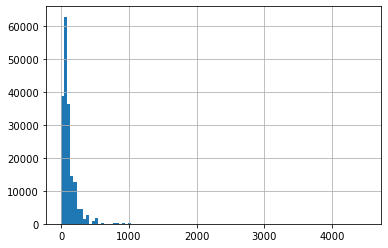

In [28]:
inp["RATE"].loc[inp["LABEL"] == "Fentanyl"].hist(bins=100)

### Cleaning

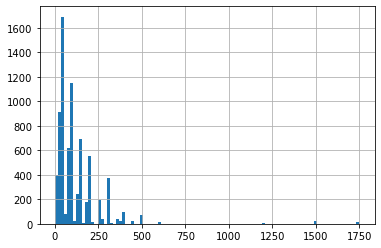

In [29]:
inp["RATE"].loc[inp["LABEL"] == "Fentanyl (Conc)"].hist(bins=100)

In [30]:
inp.groupby("LABEL")["AMOUNT"].describe()

count         mean          std  min         25%  \
LABEL                                                                      
.45% Normal Saline    28198.0    84.318591    90.206358  0.0   10.000000   
.9% Normal Saline    947201.0    32.130872    94.875476  0.0    5.000000   
Amiodarone            48681.0    39.463448    26.717406  0.0   29.999998   
Ativan                25819.0     4.610701     9.645295  0.0    1.000000   
Calcium Gluconate     12009.0     4.172966    21.880018  0.0    1.000000   
Carrier               21038.0    11.990953    27.633499  0.0    5.000000   
Cisatracurium          9234.0    14.616741    13.678844  0.0    6.000000   
D5/.45NS              89849.0    80.501845    68.610703  0.0   30.000000   
D5NS                  15293.0    91.250778    82.951116  0.0   50.000000   
D5W                 1105840.0    39.765109    88.487299  0.0    7.300000   
Diltiazem             11723.0    11.000124    10.150339  0.0    5.000000   
Dobutamine            11239.0    23.408039    34.217201  0.0    7.308750   
Dopamine              25385.0    28.204160    33.607795  0.0    9.600000   
Epinephrine-k         17471.0     0.155540     0.483486  0.0    0.045450   
Esmolol                5224.0   552.985496   672.285369  0.0  146.250000   
Fentanyl             136905.0   121.521082   167.087268  0.0   50.000000   
Fentanyl (Conc)        5263.0   154.522319   202.084548  0.0   50.000000   
Gastric Meds          48479.0    68.399938    94.293570  0.0   30.000000   
Heparin              111381.0  1199.147600  1330.189620  0.0  700.000000   
Impact w/fiber        49078.0    62.364949    45.051903  0.0   30.000000   
Insulin              148979.0     4.028115     5.649271  0.0    1.500000   
Integrelin             7469.0    10.231018     8.433152  0.0    5.760000   
KCL                  131569.0     6.561485     9.487989  0.0    0.200000   
Labetolol             11700.0    89.697207   119.908918  0.0   18.000000   
Lactated Ringers     105474.0   165.160974   235.735691  0.0   20.000000   
Lasix                 24202.0     7.883016     9.321910  0.0    2.500000   
Levophed-k            71938.0     0.702866     1.356128  0.0    0.144000   
Midazolam             87892.0     4.489570     6.366188  0.0    1.500000   
Milrinone             27652.0     1.471711     1.246824  0.0    0.691500   
Morphine Sulfate      14189.0    10.738576    63.749045  0.0    2.000000   
Natrecor               8203.0     0.092516     0.082041  0.0    0.048000   
Neosynephrine-k      108299.0     5.191758     9.500792  0.0    0.959400   
Nepro                 15954.0    37.494578    26.577018  0.0   20.000000   
Nicardipine            6933.0     7.342854     8.651047  0.0    2.100000   
Nitroglycerine-k      50575.0     5.420002     7.560160  0.0    0.397500   
Nitroprusside         22774.0     6.256971     9.566078  0.0    1.200000   
Packed RBC's          17979.0   295.770171   238.663952  0.0  150.000000   
Po Intake             93340.0   151.932314   127.313462  0.0   60.000000   
Precedex               5935.0    40.778533    32.632082  0.0   16.580001   
ProBalance            20161.0    52.277728    32.324195  0.0   35.000000   
Promote w/fiber       69384.0    58.496932    41.355786  0.0   30.000000   
Propofol             183777.0   178.639887   201.579381  0.0   66.240001   
Replete w/fiber       22567.0    55.802880    33.157301  0.0   40.000000   
Respalor              13040.0    51.479109    32.904095  0.0   35.000000   
Sandostatin            7279.0    55.304321    31.822904  0.0   49.999998   
Sodium Bicarbonate     8096.0    18.631943    27.739397  0.0    6.666667   
TF Residual           35426.0    28.585573    54.677298  0.0    0.000000   
TPN                   54674.0    66.010947    37.277902  0.0   42.599998   
Tube Feeding          22669.0    54.041368    36.763093  0.0   30.000000   
Vasopressin           26542.0     2.638422     4.643785  0.0    1.800000   

                            50%          75%            max  
LABEL    

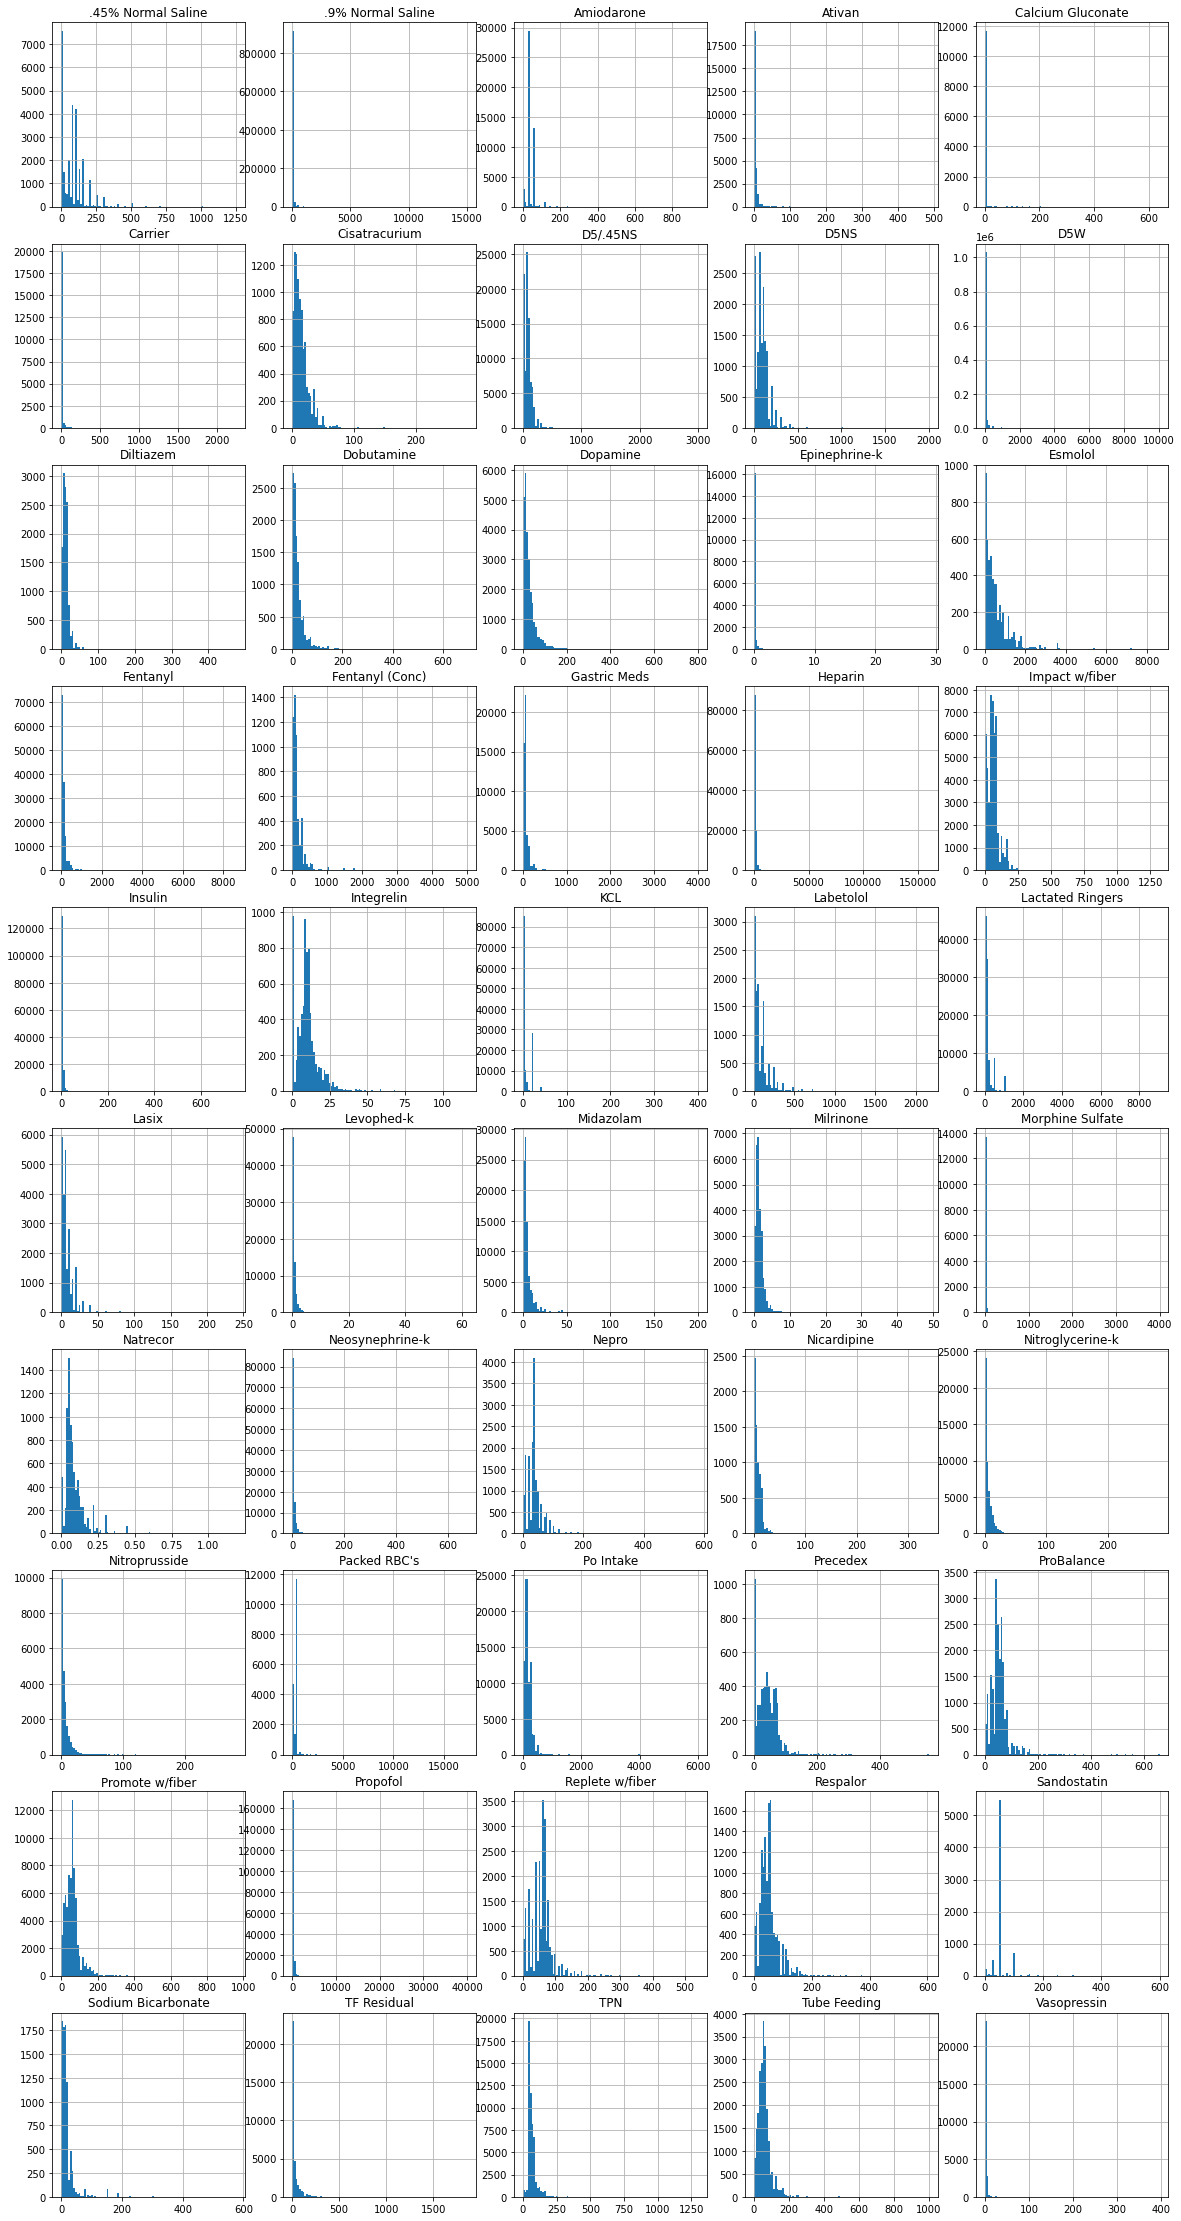

In [31]:
plt.figure(figsize=(20, 40))
for i, label in enumerate(sorted(inp["LABEL"].unique())):
    plt.subplot(10, 5, 1+i)
    inp["AMOUNT"][inp["LABEL"] == label].hist(bins=100)
    plt.title(label)

In [32]:
# # Acetaminophen-IV - remove values under and floating point errors
# inp = inp.drop(inp.loc[(inp["label"] == "Acetaminophen-IV") & (inp["amount"] < 1000)].index)
# inp["amount"].loc[inp["label"] == "Acetaminophen-IV"] = 1000

# # Albumin 5% - remove values over 500
# inp = inp.drop(inp.loc[(inp["label"] == "Albumin 5%") & (inp["amount"] > 500)].index)

# # Calcium Gluconate - remove values over 10
# inp = inp.drop(inp.loc[(inp["label"] == "Calcium Gluconate") & (inp["amount"] > 10)].index)

# # Calcium Gluconate (CRRT) - remove values over 20
# inp = inp.drop(inp.loc[(inp["label"] == "Calcium Gluconate (CRRT)") & (inp["amount"] > 20)].index)

# # Cefazolin - remove values over 1.0
# inp = inp.drop(inp.loc[(inp["label"] == "Cefazolin") & (inp["amount"] > 1)].index)

# # Cefepime - remove values over 1.0
# inp = inp.drop(inp.loc[(inp["label"] == "Cefepime") & (inp["amount"] > 1)].index)

# # Dexmedetomidine (Precedex) - remove values over 1000
# inp = inp.drop(inp.loc[(inp["label"] == "Dexmedetomidine (Precedex)") & (inp["amount"] > 1000)].index)

# # Dextrose 5% - remove values over 1000
# inp = inp.drop(inp.loc[(inp["label"] == "Dextrose 5%") & (inp["amount"] > 1000)].index)

# # Epinephrine - ???

# # Famotidine (Pepcid)

# # Fentanyl - ???

# # Free Water - remove values over 500
# inp = inp.drop(inp.loc[(inp["label"] == "Free Water") & (inp["amount"] > 500)].index)

# # Furosemide (Lasix) - ???
# # Furosemide (Lasix) - remove values over 300
# inp = inp.drop(inp.loc[(inp["label"] == "Furosemide (Lasix)") & (inp["amount"] > 300)].index)

# # GT Flush - remove values over 500
# inp = inp.drop(inp.loc[(inp["label"] == "GT Flush") & (inp["amount"] > 500)].index)

# # Gastric Meds - ???

# # Heparin Sodium

# # Heparin Sodium (Prophylaxis)

# # Hydralazine

# # Hydromorphone (Dilaudid) - ???
# # Hydromorphone (Dilaudid) - remove values over 20
# inp = inp.drop(inp.loc[(inp["label"] == "Hydromorphone (Dilaudid)") & (inp["amount"] > 20)].index)

# # Insulin - Glargine - ???

# # Insulin - Humalog

# # Insulin - Regular

# # KCL (Bolus) - ???
# # KCL (Bolus) - remove values over 100
# inp = inp.drop(inp.loc[(inp["label"] == "KCL (Bolus)") & (inp["amount"] > 100)].index)

# # KCl (CRRT) - remove values over 10
# inp = inp.drop(inp.loc[(inp["label"] == "KCl (CRRT)") & (inp["amount"] > 10)].index)

# # LR - remove values over 1000
# inp = inp.drop(inp.loc[(inp["label"] == "LR") & (inp["amount"] > 1000)].index)

# # Labetalol

# # Lorazepam (Ativan) - remove values over 10
# inp = inp.drop(inp.loc[(inp["label"] == "Lorazepam (Ativan)") & (inp["amount"] > 10)].index)

# # Magnesium Sulfate	- remove values over 2
# inp = inp.drop(inp.loc[(inp["label"] == "Magnesium Sulfate") & (inp["amount"] > 2)].index)

# # Magnesium Sulfate (Bolus) - remove values over 100
# inp = inp.drop(inp.loc[(inp["label"] == "Magnesium Sulfate (Bolus)") & (inp["amount"] > 100)].index)

# # Metoprolol - remove values over 20
# inp = inp.drop(inp.loc[(inp["label"] == "Metoprolol") & (inp["amount"] > 20)].index)

# # Metronidazole

# # Midazolam (Versed) - remove values over 100
# inp = inp.drop(inp.loc[(inp["label"] == "Midazolam (Versed)") & (inp["amount"] > 100)].index)

# # Morphine Sulfate - remove values over 10
# inp = inp.drop(inp.loc[(inp["label"] == "Morphine Sulfate") & (inp["amount"] > 10)].index)

# # NaCl 0.9% - remove values over 1000
# inp = inp.drop(inp.loc[(inp["label"] == "NaCl 0.9%") & (inp["amount"] > 1000)].index)

# # Nicardipine

# # Nitroglycerin - remove values over 50
# inp = inp.drop(inp.loc[(inp["label"] == "Nitroglycerin") & (inp["amount"] > 50)].index)

# # Norepinephrine - remove values over 10
# inp = inp.drop(inp.loc[(inp["label"] == "Norepinephrine") & (inp["amount"] > 10)].index)

# # OR Crystalloid Intake - remove values over 10000
# inp = inp.drop(inp.loc[(inp["label"] == "OR Crystalloid Intake") & (inp["amount"] > 10000)].index)

# # PO Intake

# # Packed Red Blood Cells - remove values over 500
# inp = inp.drop(inp.loc[(inp["label"] == "Packed Red Blood Cells") & (inp["amount"] > 500)].index)

# # Pantoprazole (Protonix) - remove values over 1.0
# inp = inp.drop(inp.loc[(inp["label"] == "Pantoprazole (Protonix)") & (inp["amount"] > 1.0)].index)

# # Piggyback - ???
# # Piggyback - remove values over 600
# inp = inp.drop(inp.loc[(inp["label"] == "Piggyback") & (inp["amount"] > 600)].index)

# # Piperacillin/Tazobactam (Zosyn) - remove values over 1.0
# inp = inp.drop(inp.loc[(inp["label"] == "Piperacillin/Tazobactam (Zosyn)") & (inp["amount"] > 1.0)].index)

# # Potassium Chloride - remove values over 20.001 (rounding error)
# inp = inp.drop(inp.loc[(inp["label"] == "Potassium Chloride") & (inp["amount"] > 20.001)].index)

# # Propofol - remove values over 1000
# inp = inp.drop(inp.loc[(inp["label"] == "Propofol") & (inp["amount"] > 1000)].index)

# # Replete with Fiber (Full)

# # Solution
# inp = inp.drop(inp.loc[(inp["label"] == "Solution") & (inp["amount"] > 250)].index)

# # Sterile Water
# inp = inp.drop(inp.loc[(inp["label"] == "Sterile Water") & (inp["amount"] > 100)].index)

# # Vancomycin
# inp = inp.drop(inp.loc[(inp["label"] == "Vancomycin") & (inp["amount"] > 10)].index)

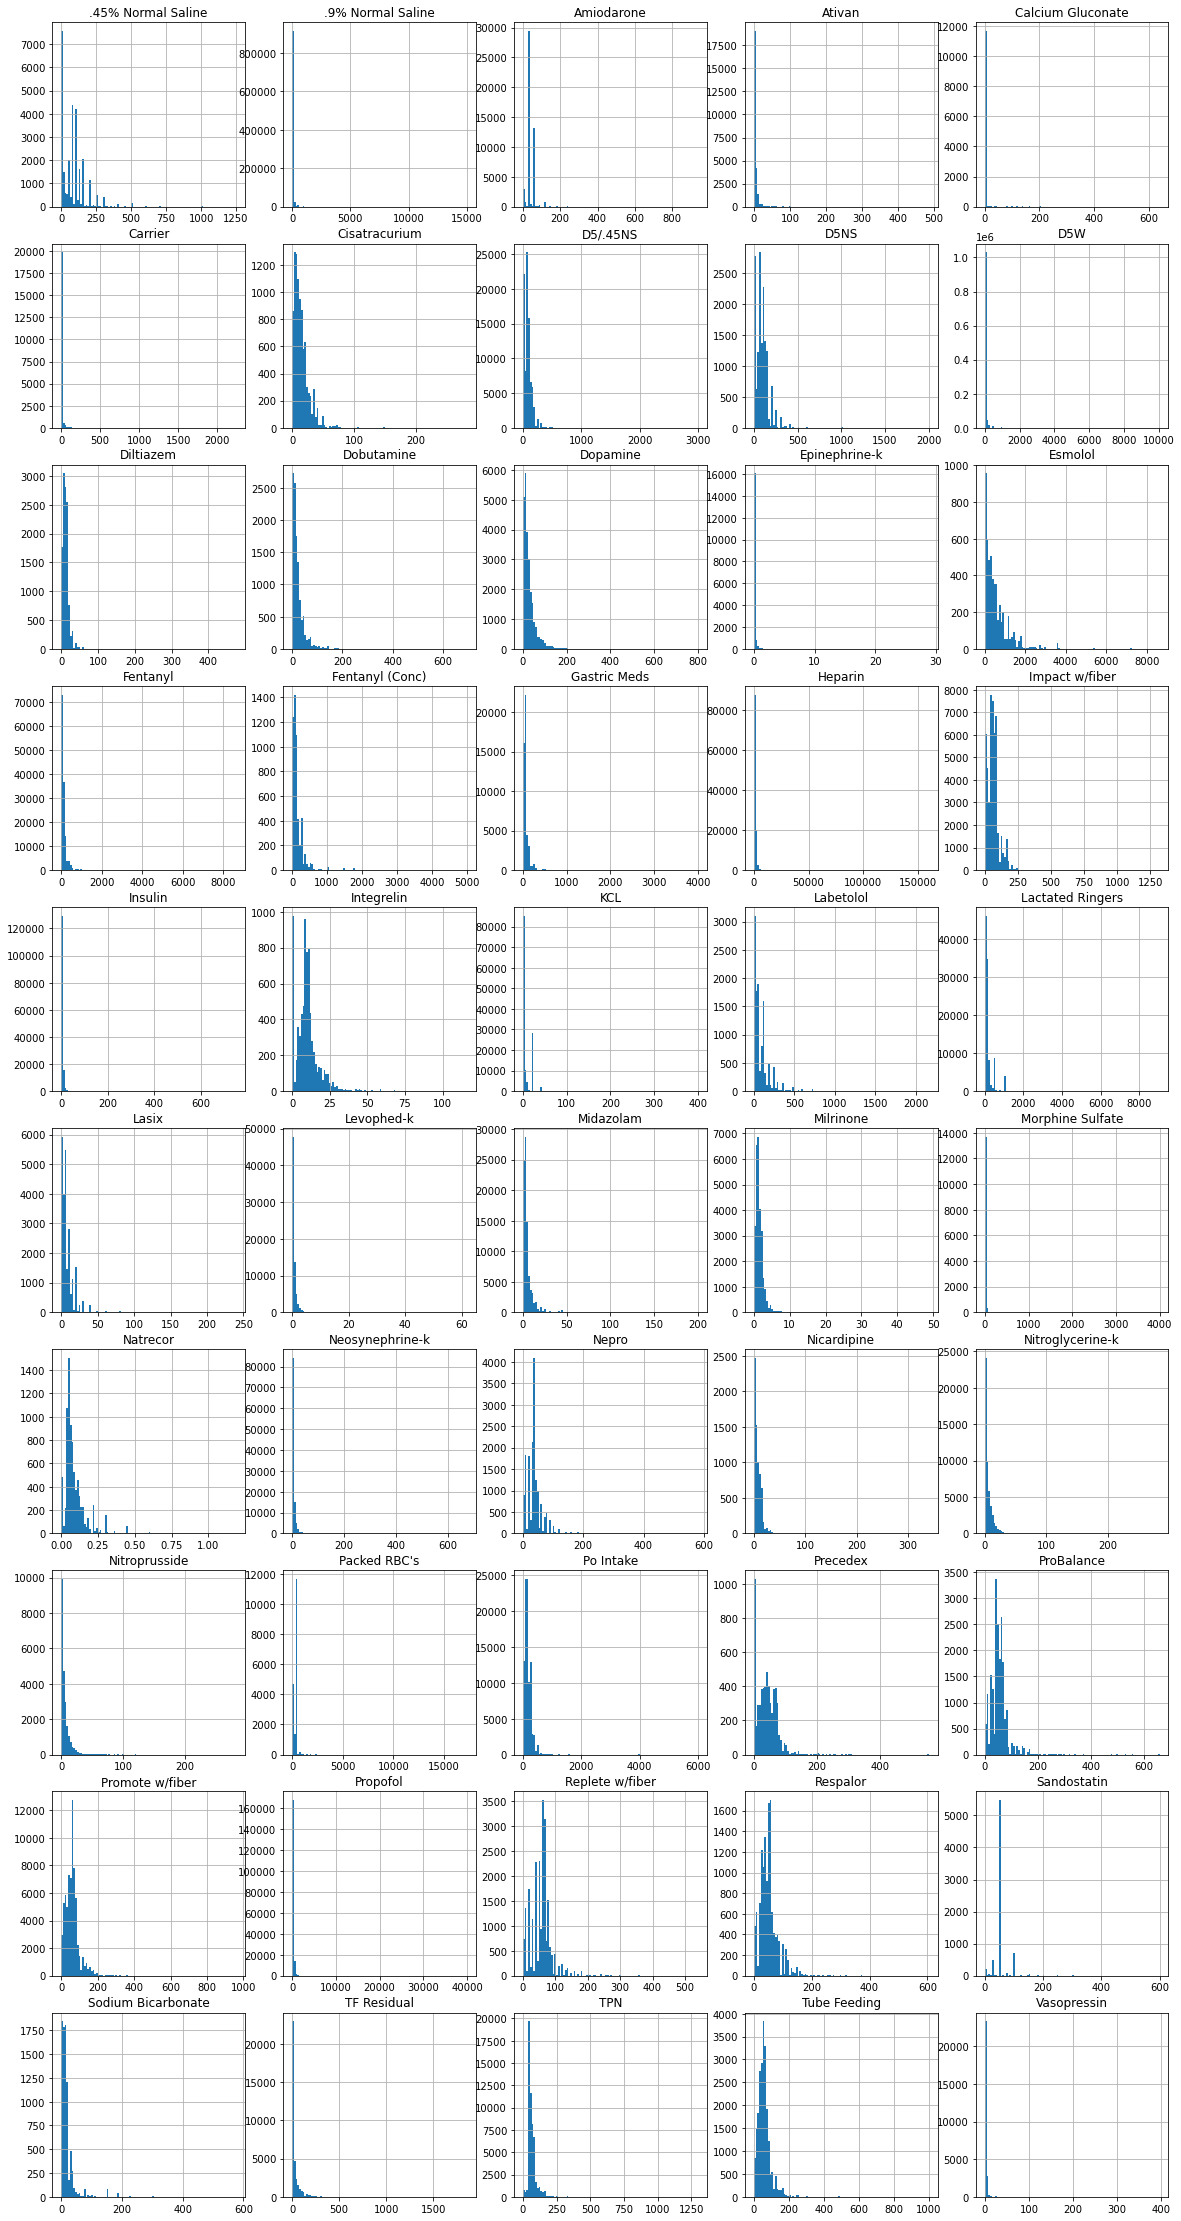

In [33]:
plt.figure(figsize=(20, 40))
for i, label in enumerate(sorted(inp["LABEL"].unique())):
    plt.subplot(10, 5, 1+i)
    inp["AMOUNT"][inp["LABEL"] == label].hist(bins=100)
    plt.title(label)

## GaussRank rescaling

In [34]:
# from gauss_rank_scaler import GaussRankScaler

# fig, axes = plt.subplots(10, 5, figsize=(20, 40))
# axes = [ax for sub_ax in axes for ax in sub_ax]
# for i, label in enumerate(sorted(inp["LABEL"].unique())):
#     scaler = GaussRankScaler()
#     series = inp["AMOUNT"][inp["LABEL"] == label]
#     if len(np.unique(series)) > 1:
#         X_train_new = scaler.fit_transform(series[:, np.newaxis])
#     else:
#         X_train_new = series[:, np.newaxis]
#     pd.DataFrame(X_train_new, columns=[label]).hist(ax=axes[i], bins=100)

ModuleNotFoundError: No module named 'gauss_rank_scaler'

In [36]:
inp.groupby("LABEL")["RATE"].describe()

count         mean         std  min         25%  \
LABEL                                                                    
.45% Normal Saline       0.0          NaN         NaN  NaN         NaN   
.9% Normal Saline        0.0          NaN         NaN  NaN         NaN   
Amiodarone           68915.0     0.639660    1.310676  0.0    0.500000   
Ativan               38056.0     3.208676    3.536347  0.0    1.000000   
Calcium Gluconate        0.0          NaN         NaN  NaN         NaN   
Carrier                  0.0          NaN         NaN  NaN         NaN   
Cisatracurium            0.0          NaN         NaN  NaN         NaN   
D5/.45NS                 0.0          NaN         NaN  NaN         NaN   
D5NS                     0.0          NaN         NaN  NaN         NaN   
D5W                      0.0          NaN         NaN  NaN         NaN   
Diltiazem            16313.0     9.982989    6.509912  0.0    5.000000   
Dobutamine           17104.0     4.275453    3.869529  0.0    2.000000   
Dopamine             40934.0     5.487762    4.848115  0.0    2.000000   
Epinephrine-k        27681.0     0.041072    0.159033  0.0    0.012000   
Esmolol                  0.0          NaN         NaN  NaN         NaN   
Fentanyl            182209.0   107.823658  111.225179  0.0   50.000000   
Fentanyl (Conc)       7513.0   123.244177  152.744699  0.0   50.000000   
Gastric Meds             0.0          NaN         NaN  NaN         NaN   
Heparin             146451.0  1006.466607  514.156118  0.0  700.000000   
Impact w/fiber           0.0          NaN         NaN  NaN         NaN   
Insulin             209850.0     3.922427    6.066668  0.0    2.000000   
Integrelin           10857.0     1.754307    0.733991  0.0    1.867816   
KCL                      0.0          NaN         NaN  NaN         NaN   
Labetolol            18292.0     1.277823    1.627712  0.0    0.500000   
Lactated Ringers         0.0          NaN         NaN  NaN         NaN   
Lasix                29993.0     7.103458    6.137881  0.0    3.000000   
Levophed-k          113053.0     0.147530    0.292165  0.0    0.038480   
Midazolam           115991.0     4.030638    5.080132  0.0    1.000000   
Milrinone            40879.0     0.306516    0.165848  0.0    0.200000   
Morphine Sulfate     22606.0     7.848922   20.855192  0.0    2.000000   
Natrecor                 0.0          NaN         NaN  NaN         NaN   
Neosynephrine-k     170830.0     1.082376    1.462224  0.0    0.300000   
Nepro                    0.0          NaN         NaN  NaN         NaN   
Nicardipine              0.0          NaN         NaN  NaN         NaN   
Nitroglycerine-k     82385.0     1.158757    1.747688  0.0    0.250000   
Nitroprusside        38177.0     1.204038    1.421192  0.0    0.300000   
Packed RBC's             0.0          NaN         NaN  NaN         NaN   
Po Intake                0.0          NaN         NaN  NaN         NaN   
Precedex                 0.0          NaN         NaN  NaN         NaN   
ProBalance               0.0          NaN         NaN  NaN         NaN   
Promote w/fiber          0.0          NaN         NaN  NaN         NaN   
Propofol            274611.0    33.648339   23.181515  0.0   20.000000   
Replete w/fiber          0.0          NaN         NaN  NaN         NaN   
Respalor                 0.0          NaN         NaN  NaN         NaN   
Sandostatin           9519.0    48.682782   11.586859  0.0   50.000000   
Sodium Bicarbonate       0.0          NaN         NaN  NaN         NaN   
TF Residual              0.0          NaN         NaN  NaN         NaN   
TPN                      0.0          NaN         NaN  NaN         NaN   
Tube Feeding             0.0          NaN         NaN  NaN         NaN   
Vasopressin              0.0          NaN         NaN  NaN         NaN   

                           50%          75%      max  
LABEL                                                 
.45% Normal Saline         NaN          NaN      NaN  
.9% Norma

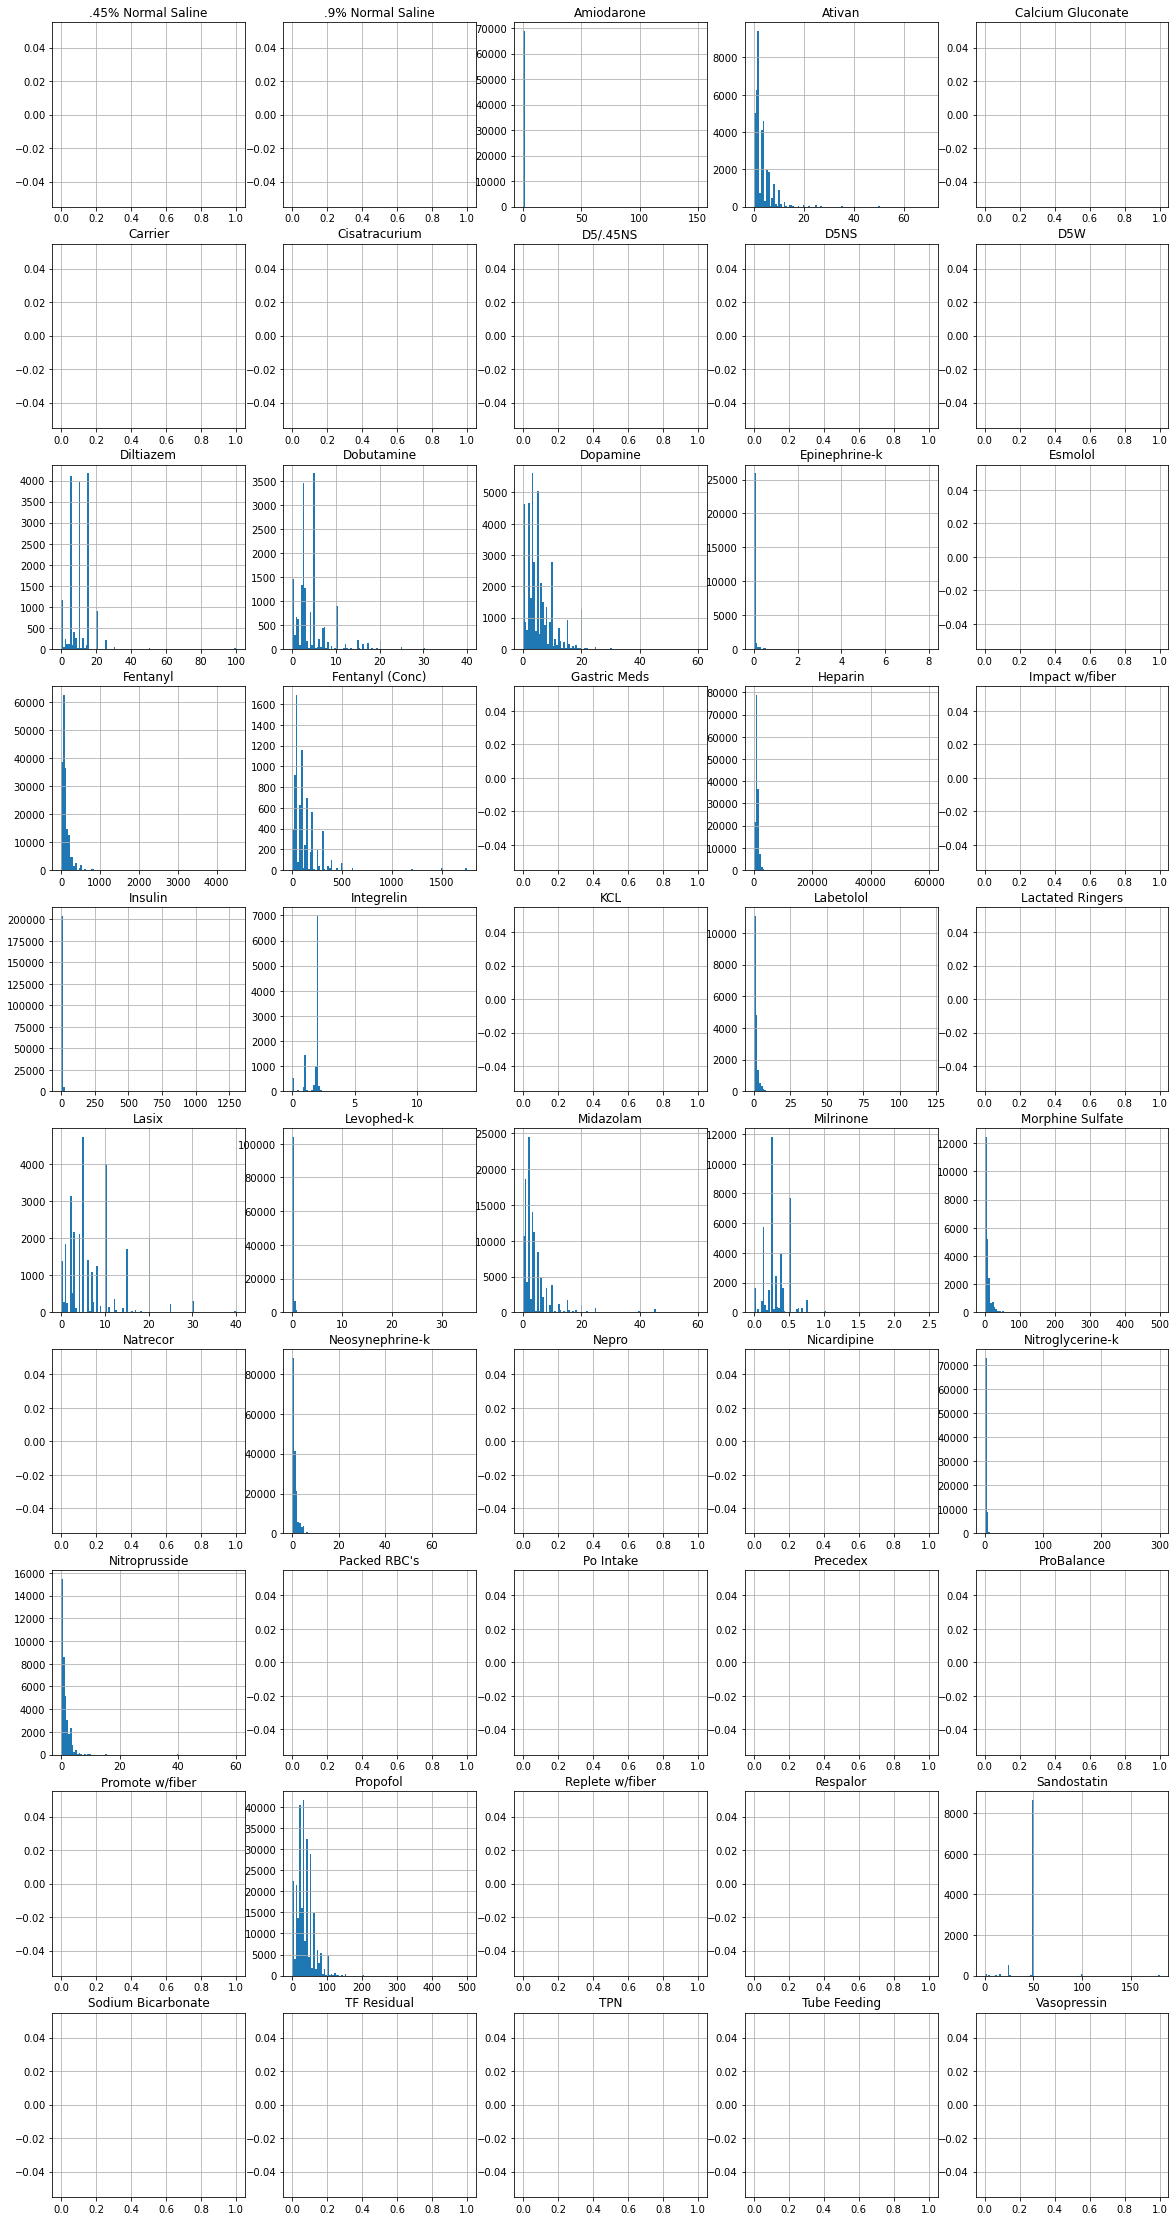

In [35]:
plt.figure(figsize=(20, 40))
for i, label in enumerate(sorted(inp["LABEL"].unique())):
    plt.subplot(10, 5, 1+i)
    inp["RATE"][inp["LABEL"] == label].hist(bins=100)
    plt.title(label)

In [ ]:
# Cleaning

In [ ]:
plt.figure(figsize=(20, 40))
for i, label in enumerate(sorted(inp["LABEL"].unique())):
    plt.subplot(10, 5, 1+i)
    inp["RATE"][inp["LABEL"] == label].hist(bins=100)
    plt.title(label)

In [33]:
inp.to_csv(os.path.join(save_path, 'inputevents.csv'))